In [1]:
import pandas as pd


merged_data=pd.read_csv('Merged Data Akshansh Roy.csv')
# Sort the dataset by DateTime
merged_data.sort_values(by='DateTime', inplace=True)

# Choose the split point based on your specific dataset
# For example, split at 80% for training, 20% for validation
split_index = int(len(merged_data) * 0.8)  # Adjust percentage as needed

# Split the dataset
train_data = merged_data.iloc[:split_index]
val_data = merged_data.iloc[split_index:]

# Optionally, reset index if needed
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Print the shapes to verify
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)


Training data shape: (24595, 19)
Validation data shape: (6149, 19)


In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# Sort the dataset by DateTime
merged_data.sort_values(by='DateTime', inplace=True)

# Split into training and validation sets
split_index = int(len(merged_data) * 0.8)  # 80% training, 20% validation
train_data = merged_data.iloc[:split_index]
val_data = merged_data.iloc[split_index:]

# Fit ARIMA model
model_arima = ARIMA(train_data['Vehicles'], order=(5, 1, 0))  # Example order, tune as per your data
model_arima_fit = model_arima.fit()

# Forecast using the model
forecast_arima = model_arima_fit.forecast(steps=len(val_data))

# Calculate MSE
mse_arima = mean_squared_error(val_data['Vehicles'], forecast_arima)
print("ARIMA MSE:", mse_arima)


C:\Users\amban\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\amban\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\amban\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


ARIMA MSE: 477.2198091744859


C:\Users\amban\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Sort the dataset by DateTime
merged_data.sort_values(by='DateTime', inplace=True)

# Handle missing values if any
merged_data.fillna({'event': 'No Event', 'venue': 'Unknown', 'location': 'Unknown'}, inplace=True)

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
merged_data['event_encoded'] = label_encoder.fit_transform(merged_data['event'])
merged_data['venue_encoded'] = label_encoder.fit_transform(merged_data['venue'])
merged_data['location_encoded'] = label_encoder.fit_transform(merged_data['location'])

# Split into features and target
X = merged_data.drop(columns=['DateTime', 'Vehicles', 'event', 'venue', 'location'])
y = merged_data['Vehicles']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit XGBoost model
model_xgb.fit(X_train, y_train)

# Predict on validation set
pred_xgb = model_xgb.predict(X_val)

# Calculate MSE
mse_xgb = mean_squared_error(y_val, pred_xgb)
print("XGBoost MSE:", mse_xgb)


XGBoost MSE: 0.007330893692979055


In [4]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

# Sort the dataset by DateTime
merged_data.sort_values(by='DateTime', inplace=True)

# Handle missing values if any
merged_data.fillna({'event': 'No Event', 'venue': 'Unknown', 'location': 'Unknown'}, inplace=True)

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
merged_data['event_encoded'] = label_encoder.fit_transform(merged_data['event'])
merged_data['venue_encoded'] = label_encoder.fit_transform(merged_data['venue'])
merged_data['location_encoded'] = label_encoder.fit_transform(merged_data['location'])

# Split into features and target
X = merged_data.drop(columns=['DateTime', 'Vehicles', 'event', 'venue', 'location'])
y = merged_data['Vehicles']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Parameter grid for random search
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5)
}

# Randomized search
random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best MSE Score: ", -random_search.best_score_)

# Predict on validation set with best model
best_model_xgb = random_search.best_estimator_
pred_xgb = best_model_xgb.predict(X_val)

# Calculate MSE
mse_xgb = mean_squared_error(y_val, pred_xgb)
print("XGBoost MSE on Validation Set:", mse_xgb)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:  {'colsample_bytree': 0.89620017169707, 'gamma': 1.1264511743512036, 'learning_rate': 0.17714347253141746, 'max_depth': 6, 'n_estimators': 184, 'subsample': 0.8808500371762971}
Best MSE Score:  0.02779149422435821
XGBoost MSE on Validation Set: 0.0068155550825095175


In [5]:
from sklearn.metrics import mean_absolute_error

mae_xgb = mean_absolute_error(y_val, pred_xgb)
print("XGBoost MAE on Validation Set:", mae_xgb)


XGBoost MAE on Validation Set: 0.018594855330866283


In [6]:
from sklearn.metrics import mean_squared_error

rmse_xgb = mean_squared_error(y_val, pred_xgb, squared=False)
print("XGBoost RMSE on Validation Set:", rmse_xgb)


XGBoost RMSE on Validation Set: 0.08255637517787175


In [7]:
from sklearn.metrics import r2_score

r2_xgb = r2_score(y_val, pred_xgb)
print("XGBoost R² on Validation Set:", r2_xgb)


XGBoost R² on Validation Set: 0.9999829745704077


In [8]:
# Predict on validation set with best model
pred_xgb = best_model_xgb.predict(X_val)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_val, pred_xgb)
rmse_xgb = mean_squared_error(y_val, pred_xgb, squared=False)
r2_xgb = r2_score(y_val, pred_xgb)

# Print evaluation results
print("XGBoost Metrics on Validation Set:")
print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)
print("R²:", r2_xgb)

XGBoost Metrics on Validation Set:
MAE: 0.018594855330866283
RMSE: 0.08255637517787175
R²: 0.9999829745704077


Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost Metrics on Validation Set:
MAE: 0.024248285378105448
RMSE: 0.08714769103941494
R²: 0.999981028196533


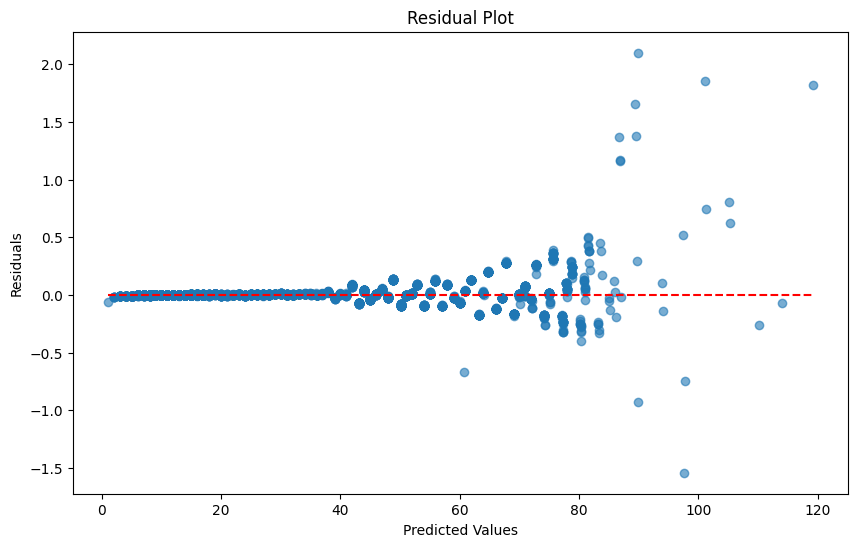

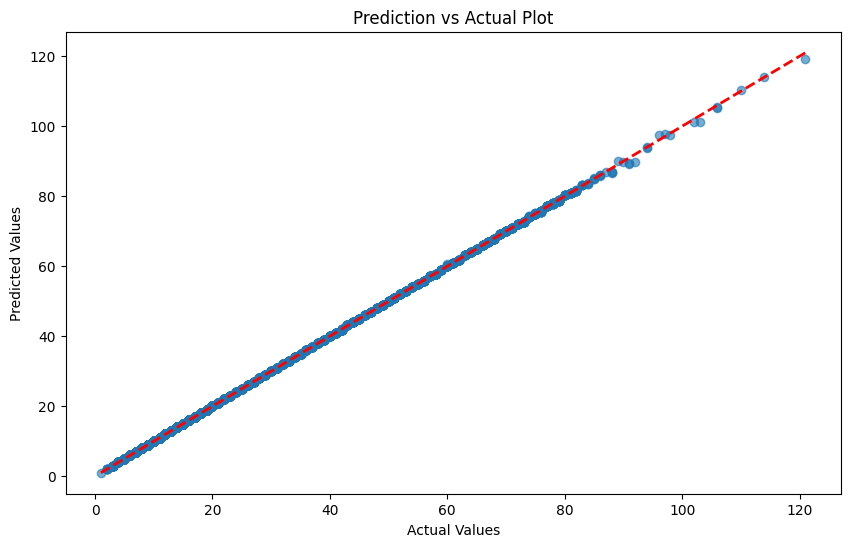

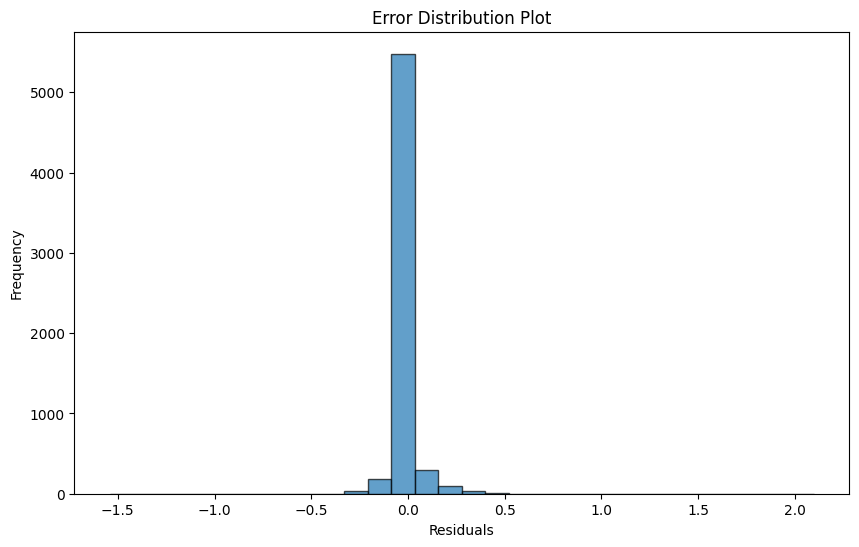

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint, uniform

# Load and preprocess your dataset (assuming 'merged_data' is your DataFrame)
# Example: Creating a synthetic merged_data for demonstration

merged_data.sort_values(by='DateTime', inplace=True)
merged_data.fillna({'event': 'No Event', 'venue': 'Unknown', 'location': 'Unknown'}, inplace=True)

label_encoder = LabelEncoder()
merged_data['event_encoded'] = label_encoder.fit_transform(merged_data['event'])
merged_data['venue_encoded'] = label_encoder.fit_transform(merged_data['venue'])
merged_data['location_encoded'] = label_encoder.fit_transform(merged_data['location'])

X = merged_data.drop(columns=['DateTime', 'Vehicles', 'event', 'venue', 'location'])
y = merged_data['Vehicles']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'gamma': uniform(0, 3)
}

random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model_xgb = random_search.best_estimator_
pred_xgb = best_model_xgb.predict(X_val)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_val, pred_xgb)
rmse_xgb = mean_squared_error(y_val, pred_xgb, squared=False)
r2_xgb = r2_score(y_val, pred_xgb)

print("XGBoost Metrics on Validation Set:")
print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)
print("R²:", r2_xgb)

# Create Visualizations

# Residual Plot
residuals = y_val - pred_xgb
plt.figure(figsize=(10, 6))
plt.scatter(pred_xgb, residuals, alpha=0.6)
plt.hlines(0, min(pred_xgb), max(pred_xgb), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, pred_xgb, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Plot')
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Error Distribution Plot')
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Aggregated XGBoost Metrics:
Mean MAE: 0.06391169383458846
Mean RMSE: 0.36989081931301226
Mean R²: 0.9987662719924664
MAE Scores per fold: [0.1260275770034016, 0.027516241375121354, 0.033826949352588995, 0.10849615469702885, 0.023691546744801492]
RMSE Scores per fold: [1.0443083815345344, 0.15908495632786998, 0.3289264578165201, 0.24007132196511663, 0.07706297892101992]
R² Scores per fold: [0.9945065987182177, 0.999872420191854, 0.9996286171493957, 0.9998387349527939, 0.9999849889500712]


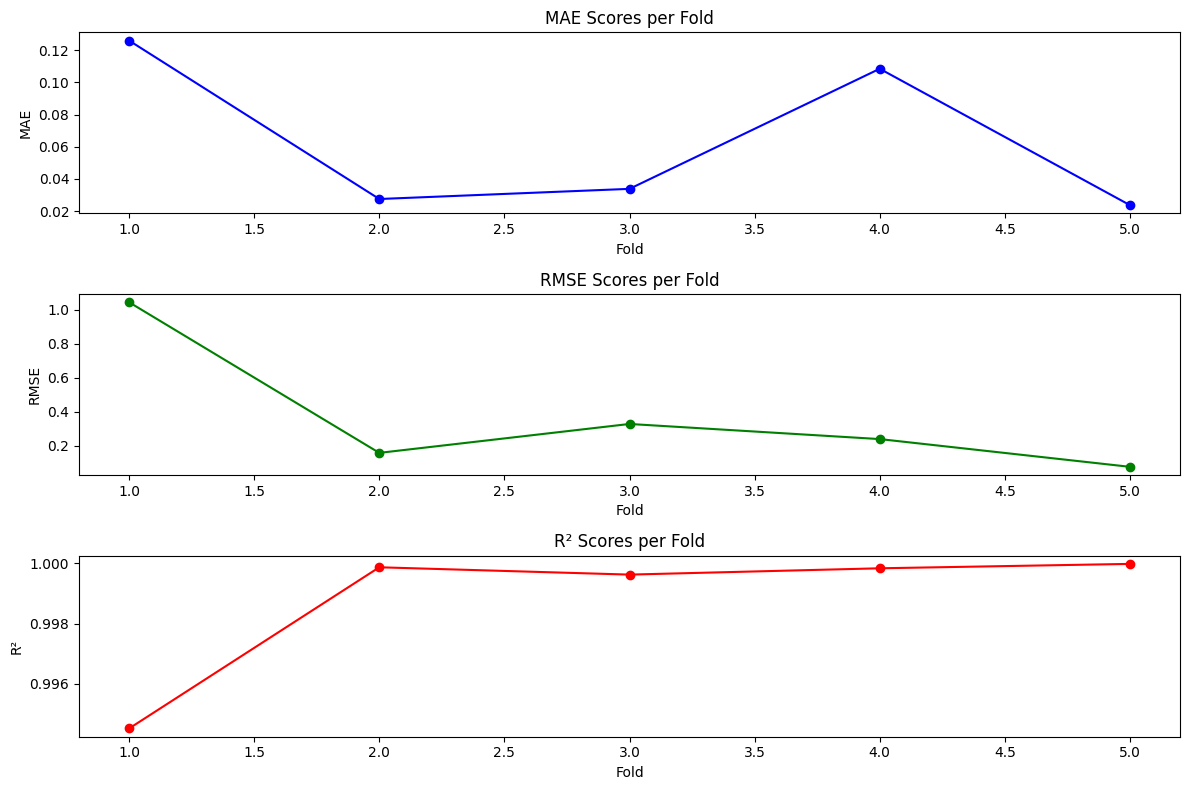

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# X, y should be your features and target variables

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Model definition and hyperparameter tuning setup
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'gamma': uniform(0, 3)
}

random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
random_search.fit(X, y)

best_model_xgb = random_search.best_estimator_

# Evaluating the model on each split
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    best_model_xgb.fit(X_train, y_train)
    pred_xgb = best_model_xgb.predict(X_val)
    
    mae = mean_absolute_error(y_val, pred_xgb)
    rmse = mean_squared_error(y_val, pred_xgb, squared=False)
    r2 = r2_score(y_val, pred_xgb)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Aggregated results
print("Aggregated XGBoost Metrics:")
print("Mean MAE:", np.mean(mae_scores))
print("Mean RMSE:", np.mean(rmse_scores))
print("Mean R²:", np.mean(r2_scores))
print("MAE Scores per fold:", mae_scores)
print("RMSE Scores per fold:", rmse_scores)
print("R² Scores per fold:", r2_scores)

# Visualizing the results
folds = range(1, tscv.get_n_splits() + 1)

plt.figure(figsize=(12, 8))

# Plot MAE scores
plt.subplot(3, 1, 1)
plt.plot(folds, mae_scores, marker='o', linestyle='-', color='b')
plt.title('MAE Scores per Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')

# Plot RMSE scores
plt.subplot(3, 1, 2)
plt.plot(folds, rmse_scores, marker='o', linestyle='-', color='g')
plt.title('RMSE Scores per Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')

# Plot R² scores
plt.subplot(3, 1, 3)
plt.plot(folds, r2_scores, marker='o', linestyle='-', color='r')
plt.title('R² Scores per Fold')
plt.xlabel('Fold')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


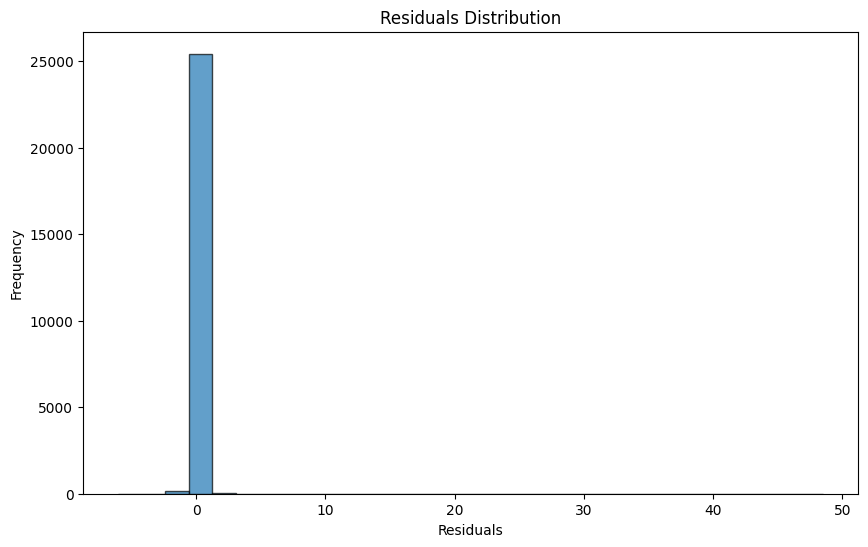

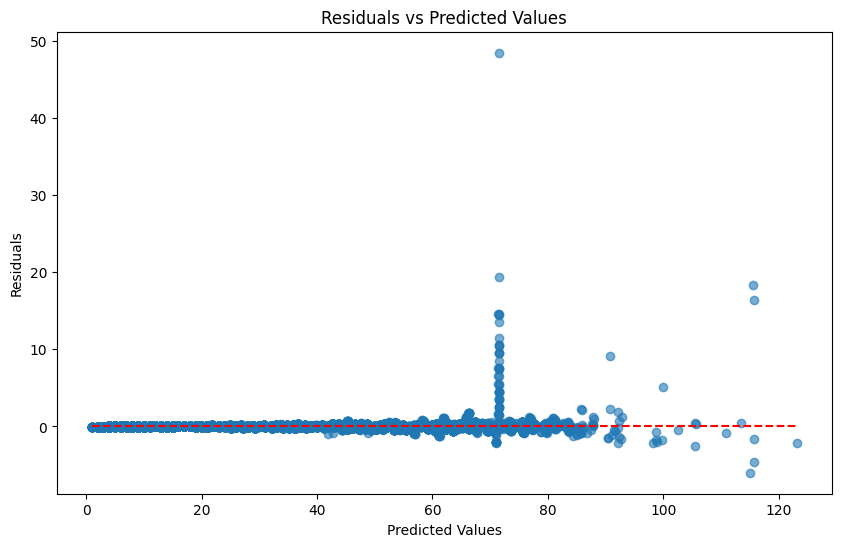

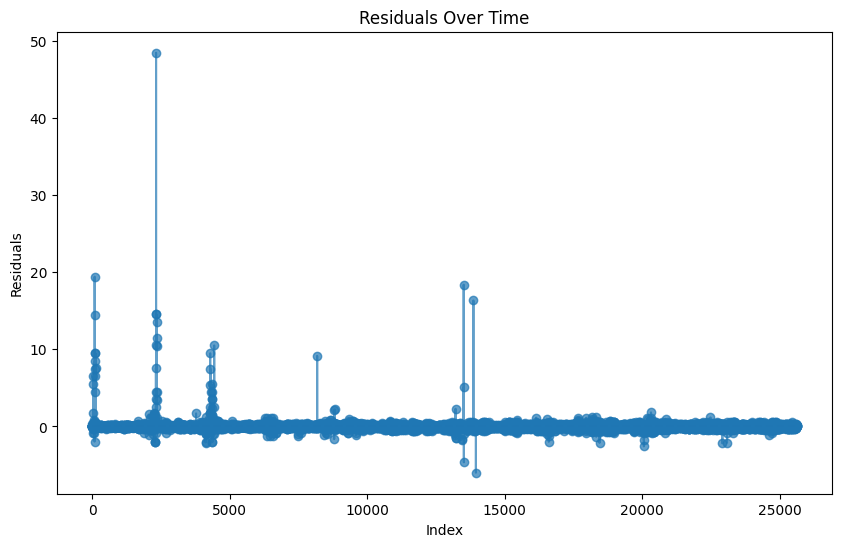

In [32]:
# Evaluating the model on each split
mae_scores = []
rmse_scores = []
r2_scores = []
residuals_all = []
pred_all = []
actual_all = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    best_model_xgb.fit(X_train, y_train)
    pred_xgb = best_model_xgb.predict(X_val)
    
    mae = mean_absolute_error(y_val, pred_xgb)
    rmse = mean_squared_error(y_val, pred_xgb, squared=False)
    r2 = r2_score(y_val, pred_xgb)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    residuals_all.extend(y_val - pred_xgb)
    pred_all.extend(pred_xgb)
    actual_all.extend(y_val)
    
    
# Error Analysis
residuals = np.array(residuals_all)
pred_all = np.array(pred_all)
actual_all = np.array(actual_all)

# Plot residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

# Scatter plot of residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(pred_all, residuals, alpha=0.6)
plt.hlines(0, min(pred_all), max(pred_all), colors='red', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Time series plot of residuals
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(residuals)), residuals, marker='o', linestyle='-', alpha=0.7)
plt.hlines(0, 0, len(residuals), colors='red', linestyles='dashed')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


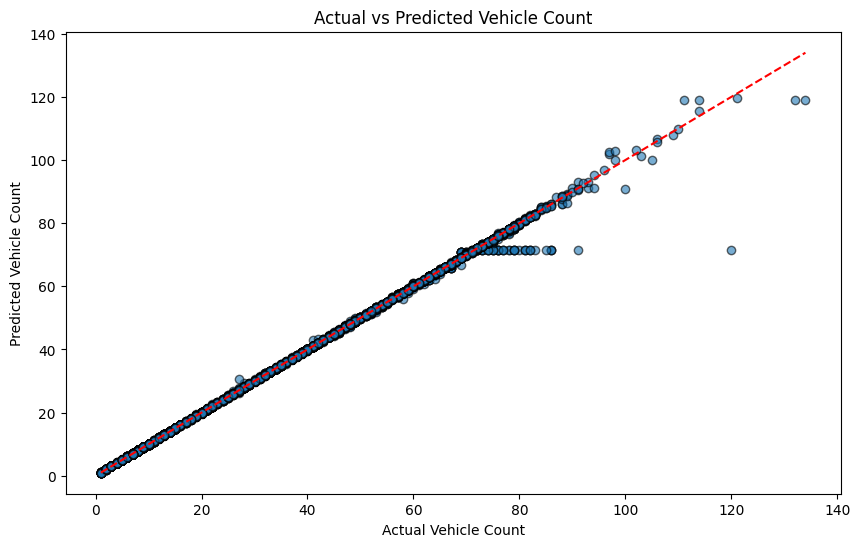

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# X, y should be your features and target variables

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Model definition and hyperparameter tuning setup
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'gamma': uniform(0, 3)
}

random_search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, n_iter=20, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
random_search.fit(X, y)

best_model_xgb = random_search.best_estimator_

# Evaluating the model on each split
pred_all = []
actual_all = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    best_model_xgb.fit(X_train, y_train)
    pred_xgb = best_model_xgb.predict(X_val)
    
    pred_all.extend(pred_xgb)
    actual_all.extend(y_val)

# Convert predictions and actuals to numpy arrays
pred_all = np.array(pred_all)
actual_all = np.array(actual_all)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(actual_all, pred_all, alpha=0.6, edgecolors='k')
plt.plot([min(actual_all), max(actual_all)], [min(actual_all), max(actual_all)], color='red', linestyle='dashed')
plt.xlabel('Actual Vehicle Count')
plt.ylabel('Predicted Vehicle Count')
plt.title('Actual vs Predicted Vehicle Count')
plt.show()
